In [93]:
import pandas as pd
import geopandas as gpd
from SPARQLWrapper import SPARQLWrapper, JSON

In [94]:
# Define the SPARQL endpoint URL
sparql_url = "https://query.wikidata.org/sparql"

# Create a SPARQLWrapper object with the defined URL
sparql = SPARQLWrapper(sparql_url)

# Define your SPARQL query
sparql_query = """
SELECT DISTINCT ?item ?itemLabel ?bmrs_id ?repd_id ?lat ?lon ?capacity ?typeLabel WHERE {
  ?item wdt:P11610 ?bmrs_id.
  OPTIONAL { ?item wdt:P9891 ?repd_id. }
  OPTIONAL { ?item wdt:P2109 ?capacity. }
  OPTIONAL {
    ?item p:P625 ?point .
    ?point psv:P625 ?point_value .
    ?point_value wikibase:geoLatitude ?lat.
    ?point_value wikibase:geoLongitude ?lon.
  }
  OPTIONAL {
    ?item wdt:P31 ?type.
    ?type wdt:P279+ wd:Q159719.
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
}
"""

# Set the query to the SPARQLWrapper object
sparql.setQuery(sparql_query)

# Set the return format to JSON (SPARQLWrapper supports XML, JSON, and others)
sparql.setReturnFormat(JSON)

# Execute the query and convert the result to a Python dictionary
results = sparql.query().convert()

In [95]:
lats = [float(result.get("lat", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
lons = [float(result.get("lon", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
bmids = [result.get("bmrs_id", {"value": "0"})["value"] for result in results["results"]["bindings"]]
repdid = [result.get("repd_id", {"value": "0"})["value"] for result in results["results"]["bindings"]]
cap = [float(result.get("capacity", {"value": "0"})["value"]) for result in results["results"]["bindings"]]
item = [result.get("item", {"value": "0"})["value"] for result in results["results"]["bindings"]]
itemlabel = [result.get("itemLabel", {"value": "0"})["value"] for result in results["results"]["bindings"]]
typelabel = [result.get("typeLabel", {"value": "0"})["value"] for result in results["results"]["bindings"]]

wiki = pd.DataFrame({
    "lat": lats,
    "lon": lons,
    "bmrs_id": bmids,
    "repd_id": repdid,
    "capacity": cap,
    "item": item,
    "itemlabel": itemlabel,
    "type": typelabel
    })

In [96]:
bm = pd.read_csv("last_week_bm.csv", index_col=[0,1,2])

print(bm.columns)
bm.loc[:, ["change"]] = bm["LevelTo"].sub(bm["LevelFrom"], axis=0)
bm.loc[:, ["abs_change"]] = bm["change"].abs()

Index(['LevelFrom', 'LevelTo', 'BmUnit'], dtype='object')


In [97]:
bm.groupby(level=2)["abs_change"].mean().sort_values(ascending=False).head(10)

NationalGridBmUnit
LON-LON01    39.091146
SPLN-1       23.807292
ROCK-1       16.872396
DINO-4       16.393229
DINO-6       14.177083
DINO-2       10.479167
HOWBO-3      10.273438
HOWBO-1      10.273438
EAS-LON01     9.565104
SSC-LON01     9.497396
Name: abs_change, dtype: float64

In [110]:
wiki.loc[wiki["lat"] == 0.]

,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
103,0.0,0.0,MILWW-1,4588,65.0,http://www.wikidata.org/entity/Q116869934,Q116869934,Q50687555
104,0.0,0.0,AKGLW-3,4332,0.0,http://www.wikidata.org/entity/Q116861310,Q116861310,Q50687555
105,0.0,0.0,AKGLW-3,4526,0.0,http://www.wikidata.org/entity/Q116861310,Q116861310,Q50687555
106,0.0,0.0,AKGLW-3,4591,0.0,http://www.wikidata.org/entity/Q116861310,Q116861310,Q50687555
107,0.0,0.0,GLNKW-1,4371,48.5,http://www.wikidata.org/entity/Q116869954,Q116869954,Q50687555
...,...,...,...,...,...,...,...,...
594,0.0,0.0,CAS-KIL01,0,0.0,http://www.wikidata.org/entity/Q116876521,Q116876521,0
595,0.0,0.0,TRMFD-1,0,0.0,http://www.wikidata.org/entity/Q116884131,Q116884131,0
596,0.0,0.0,CAS-CLU01,0,0.0,http://www.wikidata.org/entity/Q116884377,Q116884377,0
597,0.0,0.0,WTRLN-1,0,19.0,http://www.wikidata.org/entity/Q116903517,Q116903517,0


In [112]:
wiki.to_csv("wikidata.csv")

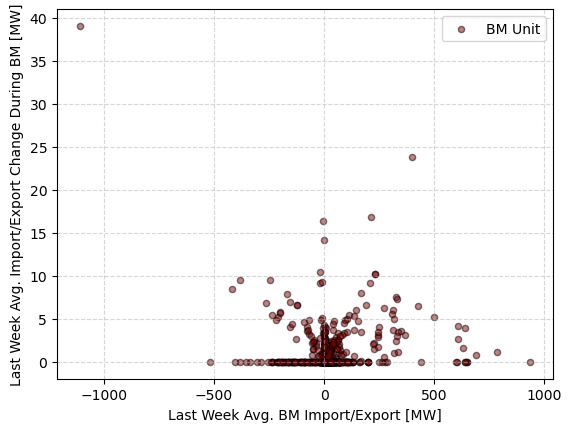

In [98]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(
    bm.groupby(level=2)["LevelTo"].mean(),
    bm.groupby(level=2)["abs_change"].mean(),
    s=20,
    c="darkred",
    alpha=0.5,
    edgecolors="k",
    label="BM Unit",
)
ax.legend()

ax.grid(True, linestyle='--', alpha=0.5)

ax.set_xlabel("Last Week Avg. BM Import/Export [MW]")
ax.set_ylabel("Last Week Avg. Import/Export Change During BM [MW]")

plt.show()

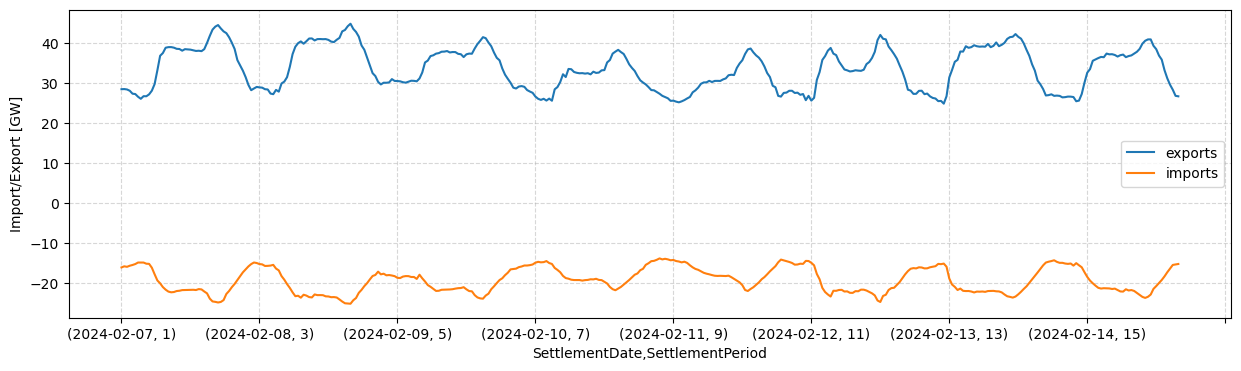

In [99]:
pos = bm.loc[bm["LevelTo"] >= 0, "LevelTo"]
neg = bm.loc[bm["LevelTo"] < 0, "LevelTo"]

fig, ax = plt.subplots(figsize=(15, 4))

pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="exports", ax=ax)
neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="imports", ax=ax)

ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_ylabel("Import/Export [GW]")
plt.show()


In [100]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

idx = pd.IndexSlice

##### Wiki

In [101]:
all_units = pd.DataFrame(index=bm.index.get_level_values(2).unique())

merged = pd.concat((
    all_units,
    wiki[["bmrs_id", "lat", "lon", "capacity"]].groupby("bmrs_id").mean(),
), axis=1).fillna(0).loc[all_units.index]

print(merged.shape)

(1874, 3)


In [102]:
found_idx = merged.loc[merged["lat"] != 0].index
wiki_found_bm = bm.loc[idx[:,:,found_idx], :]

print('found:')
print(len(found_idx))

found:
289


##### Adding Dictionary

In [103]:
web = 'https://data.elexon.co.uk/bmrs/api/v1/reference/bmunits/all'
r = requests.get(web)

# last updated Jan 2023
df_ids = pd.read_csv('../data/ids.csv', index_col=0)
# last updated Jan 2023
df_loc = pd.read_csv('../data/plant-locations.csv', index_col=0)

hold = merged.copy()
for name in all_units.index:

    row = df_ids.loc[df_ids['ngc_bmu_id'].fillna('').str.contains(name)]

    if row.empty:
        continue

    bmu_id = row.index[0]

    try:
        merged.loc[name, 'lat'] = df_loc.loc[row.index[0], 'latitude'] or np.nan
        merged.loc[name, 'lon'] = df_loc.loc[row.index[0], 'longitude'] or np.nan
    except KeyError:
        continue


In [104]:
found_idx = merged.loc[merged["lat"] != 0].index
wikidict_found_bm = bm.loc[idx[:,:,found_idx], :]

print('found:')
print(len(found_idx))

found:
382


##### Adding Manual data

In [167]:
import pandas as pd
from pathlib import Path

manual = pd.read_csv(Path.cwd().parent / "data" / "manual_bmus.csv")
all_found = found_idx.tolist() + manual["nationalGridBmUnit"].tolist()

allfound_bm = bm.loc[idx[:,:,all_found], :]

#### Summary

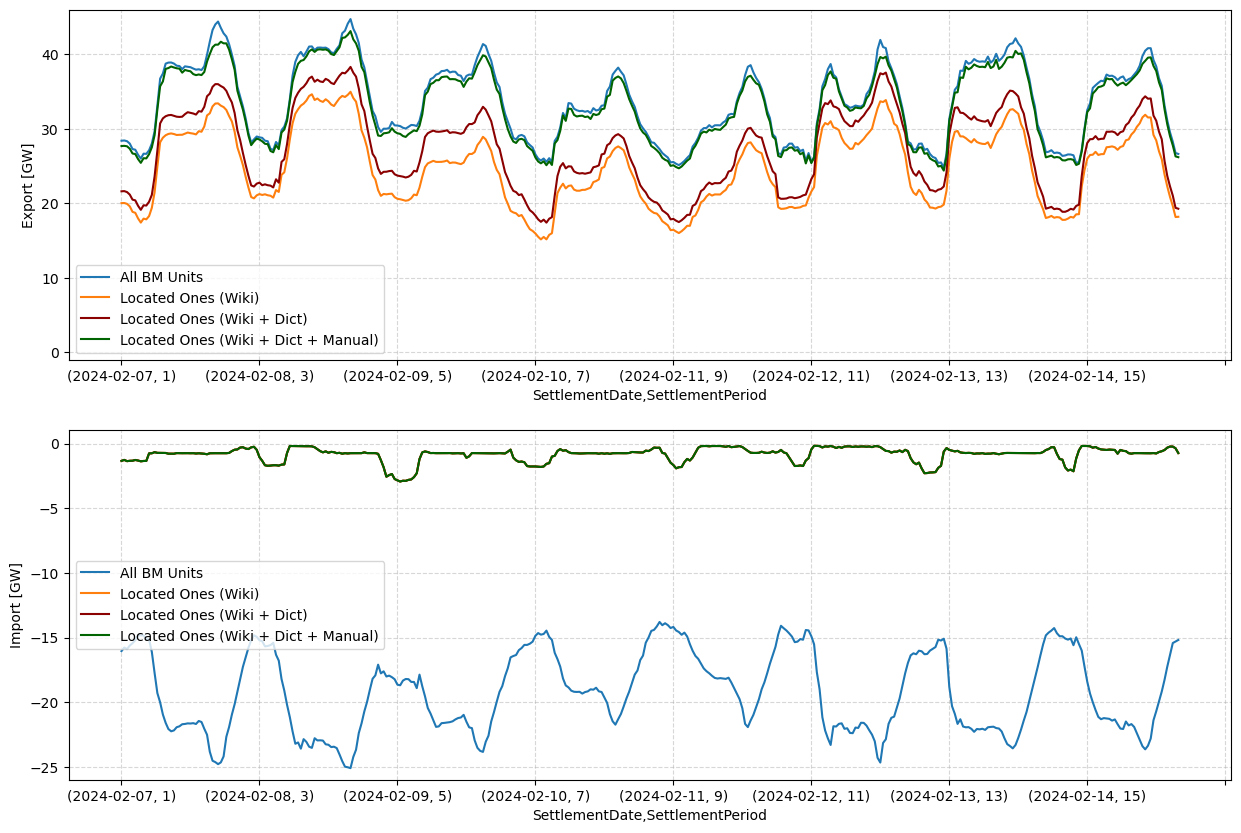

In [168]:
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

split = lambda df: (df.loc[df["LevelTo"] >= 0, "LevelTo"], df.loc[df["LevelTo"] < 0, "LevelTo"])

pos, neg = split(bm)
wiki_found_pos, wiki_found_neg = split(wiki_found_bm)
wikidict_found_pos, wikidict_found_neg = split(wikidict_found_bm)
allfound_pos, allfound_neg = split(allfound_bm)

pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="All BM Units", ax=axs[0])
neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="All BM Units", ax=axs[1])

wiki_found_pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki)", ax=axs[0])
wiki_found_neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki)", ax=axs[1])

wikidict_found_pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki + Dict)", ax=axs[0], color="darkred")
wikidict_found_neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki + Dict)", ax=axs[1], color="darkred")

allfound_pos.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki + Dict + Manual)", ax=axs[0], color="darkgreen")
allfound_neg.groupby(level=[0,1]).sum().mul(1e-3).plot(label="Located Ones (Wiki + Dict + Manual)", ax=axs[1], color="darkgreen")

for ax in axs:
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.5)
axs[0].set_ylabel("Export [GW]")
axs[1].set_ylabel("Import [GW]")

axs[0].set_ylim(-1, 46)
axs[1].set_ylim(-26, )

plt.show()

In [57]:
located = merged.loc[merged["lat"] != 0]
located

,lat,lon,capacity
NationalGridBmUnit,,,
PETDG-1,52.575703,-0.203798,50.0
AG-LLIM02,51.018497,-3.157186,30.0
BRGDG-1,53.540993,-0.508006,50.0
CMSTW-1,58.406935,-3.270129,50.0
RSHLW-1,58.003300,-4.550800,24.7
...,...,...,...
EDINW-1,57.279043,-6.229248,41.4
PINFB-1,53.265694,-2.943583,100.0
STLGW-3,57.099869,-4.461346,228.0


NationalGridBmUnit
IFG-GAZP1    0.741119
EAS-SEL01    0.746438
IFG-NTPL1    0.751549
ING-NEAS1    0.756547
IFG-NITR1    0.761343
YEP-PGU01    0.766111
ILG-TGPL1    0.770802
ILG-NITR1    0.775249
IVG-NORL1    0.779643
ING-STAT1    0.784014
IBG-MFTE1    0.788250
IFG-TRLS1    0.792384
ING-DSKC1    0.796475
ILG-NTPL1    0.800466
IFG-NORL1    0.804369
IFG-CONV1    0.808216
KENNW-1      0.811973
CASKD-1      0.815621
IBG-NEAS1    0.819248
TMNCW-1      0.822864
IEG-MOYL1    0.826433
SAKNW-1      0.830000
CREAW-1      0.833531
ING-TRLS1    0.837043
AG-NHAV02    0.840533
IBG-HELI1    0.843985
KYPEW-1      0.847268
SEE-PGU01    0.850288
GLNKW-1      0.853293
IFG-SETL1    0.856285
Name: LevelTo, dtype: float64


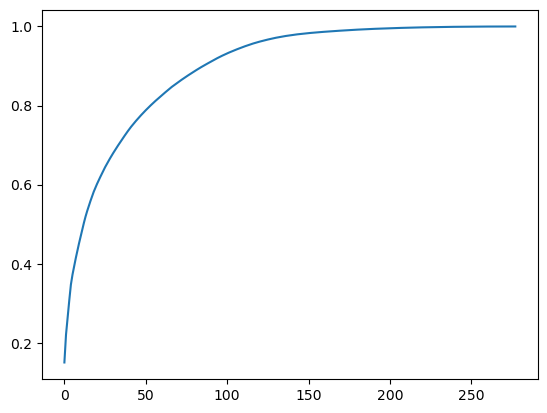

In [166]:
missing = merged.loc[merged["lat"] == 0]

missing = bm.loc[idx[:,:,missing.index], :].groupby(level=2)["LevelTo"].sum().sort_values(ascending=False)
missing = missing[missing > 0]

cumulative = missing.div(missing.sum()).cumsum()
# print(cumulative.head(30))
print(cumulative.iloc[40:70])

plt.plot(range(len(cumulative)), missing.div(missing.sum()).cumsum().values.tolist())

# print(missing.head(30))

In [150]:
wiki_counter = 0
dict_counter = 0

wiki_names = list()
dict_names = list()

for name in missing.index:

    wiki_hits = wiki.loc[wiki["bmrs_id"] == name]
    if not wiki_hits.empty:
        # print("//////////////////////////")
        # print(name)
        # print(wiki_hits.head())
        wiki_counter += 1
        wiki_names.append(name)
        continue

    dict_hits = df_ids.loc[df_ids["sett_bmu_id"].str.contains(name).fillna(False)]
    if not dict_hits.empty:
        # print("..>>>>>>>>>>>>>>>>>>>>")
        # print(name)
        # print(dict_hits.head())
        dict_counter += 1
        dict_names.append(name)
    
    # print('-------------------')

print(wiki_counter)
print(dict_counter)

total = missing.sum()
print(missing.loc[wiki_names].sum() / total)
print(missing.loc[dict_names].sum() / total)

56
0
0.06338507258487865
0.0


In [154]:
wiki.loc[wiki["bmrs_id"].isin(wiki_names)].sort_values(by="capacity", ascending=False)

,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
507,0.0,0.0,SOKYW-1,4586,240.0,http://www.wikidata.org/entity/Q115952717,Q115952717,Q50687555
583,0.0,0.0,CUMHW-1,0,126.0,http://www.wikidata.org/entity/Q123580995,Q123580995,Q50687555
373,0.0,0.0,AG-HLIM03,0,100.0,http://www.wikidata.org/entity/Q116894478,Q116894478,Q810924
354,0.0,0.0,DOLLB-1,7088,100.0,http://www.wikidata.org/entity/Q117768503,Q117768503,Q810924
374,0.0,0.0,AG-HLIM04,0,100.0,http://www.wikidata.org/entity/Q116894478,Q116894478,Q810924
336,0.0,0.0,CLAYB-2,0,99.0,http://www.wikidata.org/entity/Q122170316,Q122170316,Q810924
335,0.0,0.0,CLAYB-1,0,99.0,http://www.wikidata.org/entity/Q122170316,Q122170316,Q810924
399,0.0,0.0,PILLB-2,7005,98.0,http://www.wikidata.org/entity/Q116884358,Q116884358,Q810924
398,0.0,0.0,PILLB-1,7005,98.0,http://www.wikidata.org/entity/Q116884358,Q116884358,Q810924
325,0.0,0.0,PILLB-1,7360,98.0,http://www.wikidata.org/entity/Q116884358,Q116884358,Q810924


In [143]:
df_ids["sett_bmu_id"].str.contains(name).fillna(False).sum()

0

In [59]:
harm = gpd.read_file("harmonised_bm_units.geojson")
harm.loc[~harm["nationalGridBmUnit"].isin(located.index)]

,nationalGridBmUnit,elexonBmUnit,fuelType,leadPartyName,bmUnitType,fpnFlag,longitude,latitude,geometry
7,BAGE-1,T_BAGE-1,CCGT,Baglan Operations Ltd,T,1,-5.031738,51.720223,POINT (-5.03174 51.72022)
8,BAGE-2,T_BAGE-2,CCGT,Baglan Operations Ltd,T,1,-5.031738,51.720223,POINT (-5.03174 51.72022)
96,FIDL-1,T_FIDL-1,None,Keadby Generation Limited,T,1,-2.823486,53.350551,POINT (-2.82349 53.35055)
97,FIDL-2,T_FIDL-2,None,Keadby Generation Limited,T,1,-2.823486,53.350551,POINT (-2.82349 53.35055)
98,FIDL-2G,T_FIDL-2G,None,Keadby Generation Limited,T,1,-2.823486,53.350551,POINT (-2.82349 53.35055)
99,FIDL-3,T_FIDL-3,None,Keadby Generation Limited,T,1,-2.823486,53.350551,POINT (-2.82349 53.35055)
100,FIDL-3G,T_FIDL-3G,None,Keadby Generation Limited,T,1,-2.823486,53.350551,POINT (-2.82349 53.35055)
101,FIDL-4,T_FIDL-4,None,Keadby Generation Limited,T,1,-2.823486,53.350551,POINT (-2.82349 53.35055)
146,HUNB-7,T_HUNB-7,NUCLEAR,EDF Energy Nuclear Generation,T,1,-4.822998,55.646599,POINT (-4.82300 55.64660)
147,HUNB-8,T_HUNB-8,NUCLEAR,EDF Energy Nuclear Generation,T,1,-4.822998,55.646599,POINT (-4.82300 55.64660)


In [50]:
import geopandas as gpd

posss = merged.loc[merged.lon != 0]

posss = gpd.GeoDataFrame(posss, geometry=gpd.points_from_xy(posss.lon, posss.lat))   
posss.to_file("located.geojson", driver="GeoJSON")

In [84]:
wiki["bmrs_id"].value_counts()
wiki.query("bmrs_id == 'CRYRW-3'")

,lat,lon,bmrs_id,repd_id,capacity,item,itemlabel,type
396,55.9,-2.55,CRYRW-3,3440,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
519,55.9,-2.55,CRYRW-3,3536,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
528,55.9,-2.55,CRYRW-3,4215,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
539,55.9,-2.55,CRYRW-3,3114,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555
578,55.9,-2.55,CRYRW-3,4631,200.5,http://www.wikidata.org/entity/Q5191333,Q5191333,Q50687555


##### Data from BMU Dict

NameError: name 'np' is not defined

In [18]:
df.loc[~df['lat'].isna()]["fuelType"].value_counts()

fuelType
WIND       163
CCGT        62
NPSHYD      21
OCGT        19
PS          16
NUCLEAR     16
BIOMASS     11
COAL        10
OTHER        1
Name: count, dtype: int64

In [171]:
import geopandas as gpd

located_bmus = pd.read_csv(Path.cwd().parent / "resources/bmunits_loc.csv")
located_bmus = gpd.GeoDataFrame(located_bmus, geometry=gpd.points_from_xy(located_bmus.lon, located_bmus.lat))

located_bmus.to_file("located_bmus.geojson", driver="GeoJSON")
